In [1]:
import numpy as np
from myplotstyle import plt, get_figsize
import pandas as pd

from easyquery import Query, QueryMaker
import SAGA
from SAGA import ObjectCuts as C
from SAGA import HostCuts as H
from SAGA.database import GoogleSheets

from astropy.table import Table, join
from astropy.io import ascii
import pandas as pd

In [2]:
print(SAGA.__version__)
saga = SAGA.QuickStart()

3.0.0
SAGA `shared_dir` set to /home/yymao/Dropbox/Work/SAGA
SAGA `local_dir`  set to /home/yymao/Documents/Work/Data/SAGA


In [3]:
base = H.paper3.filter(saga.object_catalog.load_combined_base_catalog())
nhosts = len(np.unique(base["HOSTID"]))
assert nhosts == 101

In [4]:
lg = SAGA.database.FitsTable("data/McConnachie2012.fit").read()
lg["Mr"] = lg["vmag_lc"] - 0.4
lg["SubG"][np.argmax(lg["Name"] == "Pegasus dIrr")] = "M31 "
lg = (Query((np.isfinite, "vmag_lc"), ~QueryMaker.equals("Name", "Canis Major"), "Mr < -10")).filter(lg)

mw_sat_mr = np.asarray(np.sort(QueryMaker.equals("SubG", "MW  ").filter(lg, "Mr")))
m31_sat_mr = np.asarray(np.sort(QueryMaker.equals("SubG", "M31 ").filter(lg, "Mr")))

In [5]:
hostlist = (H.paper3 & C.is_host).filter(base)
sats = C.is_sat.filter(base)
base = Query(C.sat_rcut, "p_sat_corrected > 0").filter(base)

In [6]:
print("completeness limit =", np.median(-12.3 - (hostlist["Mr"])))

color_dict = np.load("data/color_dict.npz")  # generated by F06-satellite mosaic.ipynb

completeness limit = 8.793557


In [7]:
lf_data = dict()
dm_bins = np.linspace(0, 11, 15)

for base_this in base.group_by("HOSTID").groups:
    host_this = base_this["HOSTID"][0]
    host_mag = hostlist[hostlist["HOSTID"] == host_this]["Mr"][0]
    base_this = Query("p_sat_corrected > 0", C.is_sat | (~C.has_spec)).filter(base_this, ["Mr_phony", "p_sat_corrected", "SATS"])
    lf_data_this = dict()
    base_this.sort('Mr_phony')
    lf_data_this['lf_x'] = np.append(np.insert(np.vstack([base_this['Mr_phony']]*2).T.flatten(), 0, -23.0), -9.0)
    lf_data_this['lf_y_est'] = np.vstack([np.insert(np.cumsum(base_this['p_sat_corrected']), 0, 0.0)]*2).T.flatten()
    lf_data_this['lf_y'] = np.vstack([np.insert(np.cumsum(C.is_sat.mask(base_this).astype(np.int64)), 0, 0.0)]*2).T.flatten()
    lf_data_this['dm'] = np.searchsorted(C.is_sat.filter(base_this, "Mr_phony") - host_mag, dm_bins)
    lf_data_this['dm_cor'] = np.insert(np.cumsum(base_this['p_sat_corrected']),0,0)[np.searchsorted(base_this['Mr_phony'] - host_mag, dm_bins)]
    lf_data[host_this] = lf_data_this

for host_this, mr in zip(("MW", "M31"), (mw_sat_mr, m31_sat_mr)):
    lf_data_this = dict()
    lf_data_this['lf_x'] = np.append(np.insert(np.vstack([mr]*2).T.flatten(), 0, -23.0), -9.0)
    lf_data_this['lf_y'] = np.vstack([np.insert(np.arange(1, len(mr)+1), 0, 0.0)]*2).T.flatten()
    lf_data[host_this] = lf_data_this

In [8]:
lf_sales = ascii.read(format="basic", names=["dm", "n1", "n2"], data_start=0,
    table="""0.14 0.00698 0.01323
0.74 0.04821 0.10645
1.34 0.09673 0.23615
1.94 0.15467 0.40442
2.54 0.23212 0.61988
3.14 0.32869 0.87778
3.74 0.44383 1.22344
4.34 0.55660 1.61749
4.94 0.67625 2.08275""")

lf_n12 = ascii.read(format="basic", names=["dm", "n", "nl", "nu"], data_start=0,
    table="""1.5  0.15319  0.06332 0.27467
2.0  0.21857  0.11069 0.35585
2.5  0.25843  0.13981 0.39589
3.0  0.31824  0.14268 0.48504
3.5  0.52342  0.31026 0.74681
4.0  0.61890  0.42506 0.86090
4.5  0.91498  0.67128 1.18541
5.0  1.11534  0.75443 1.47465
5.5  1.84379  1.31211 2.47517
6.0  2.81017  1.99983 3.79168
6.5  0.97246  0.23586 2.11470
7.0  4.69293  2.06169 7.83712
7.5  6.72983  3.28919 9.60195""")

In [9]:
# compiled/coded by Yasmeen with https://github.com/yasmeenasali/compile_elves/blob/main/elves_data_compilation.ipynb
elves_df = pd.read_csv('data/compiled_elves_data.csv')

# from F07
hosts_matched_to_saga = "NGC253 NGC628 NGC891 NGC1023 NGC1291 NGC2683 NGC2903 NGC3115 NGC4258 NGC4736 NGC5055 NGC5236 NGC5457 NGC6744".split()

elves_df = QueryMaker.isin("HOST", hosts_matched_to_saga).filter(elves_df)

# fix one missing Mr
idx = elves_df.index[QueryMaker.equal("Name", "IC239").where(elves_df)[0]]
elves_df.loc[idx, "Mr"] = elves_df.loc[idx, "Mv"] - 0.4

if not (mask := QueryMaker.isfinite("Mr").mask(elves_df)).all():
    display(elves_df[~mask])
    elves_df = elves_df[mask]

lf_elves_data = dict()
for (hostname, group) in elves_df.groupby('HOST'):
    host_mag = group['HOST_MK'].iloc[0] + 2.5  # rough translation to Mr
    group = group.sort_values("Mr")

    lf_elves_data_this = dict()
    r_cover = group['r_cover'].iloc[0]
    lf_elves_data_this['r_cover'] = r_cover

    # define cumsum over an array of ones of length sats
    lf_elves_data_this['dm'] = np.searchsorted(group['Mr'].values[group['Confirmed']] - host_mag, dm_bins) * (300 / r_cover)
    lf_elves_data_this['dm_cor'] = np.insert(np.cumsum(group['Psat'].values),0,0)[np.searchsorted(group['Mr'] - host_mag, dm_bins)] * (300 / r_cover)
    lf_elves_data[hostname] = lf_elves_data_this

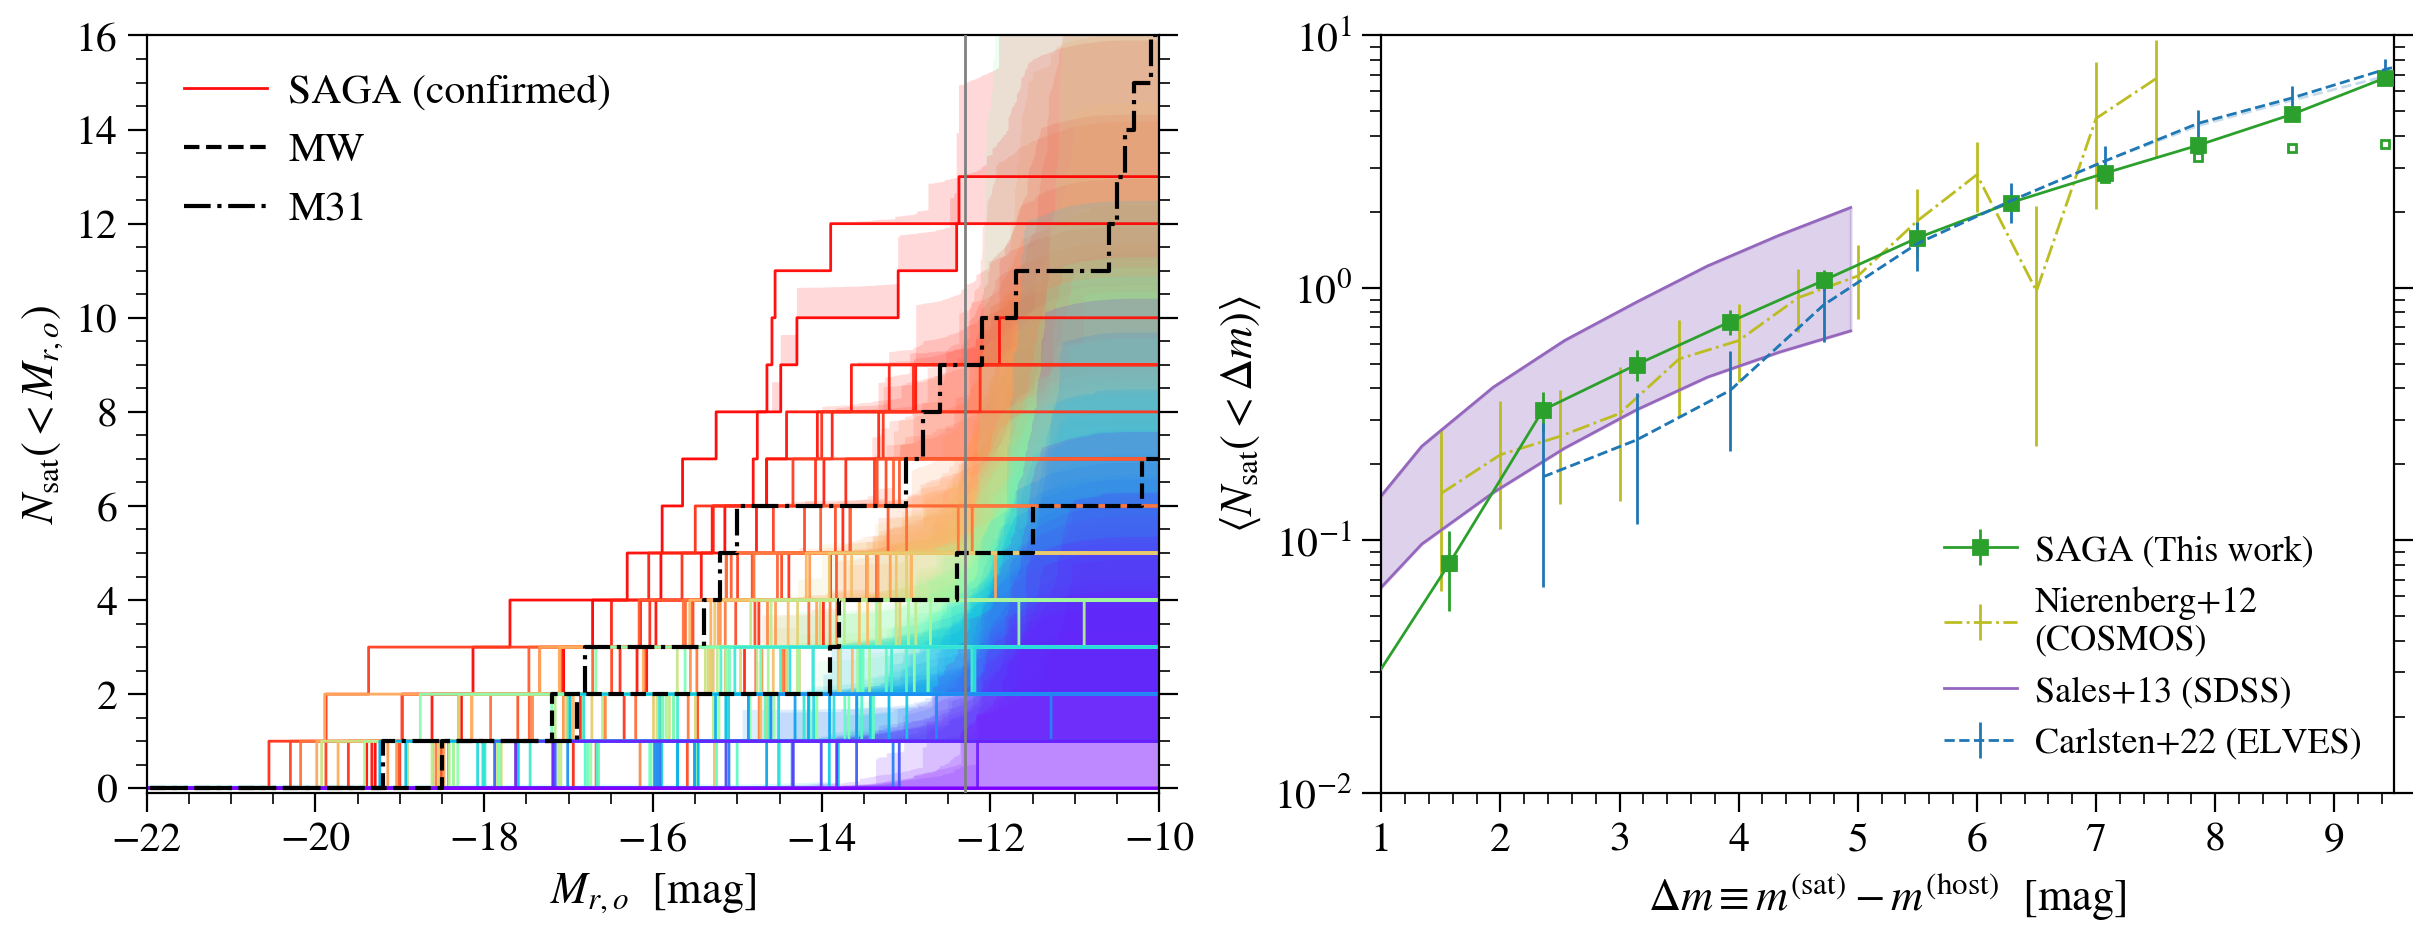

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=get_figsize(wide=True, ratio=2.7))

ax_this = ax[0]

for i, (hostid, color) in enumerate(color_dict.items()):
    host_this = hostlist[np.argmax(hostlist["HOSTID"] == hostid)]
    lf_data_this = lf_data[hostid]
    ax_this.plot(lf_data_this['lf_x'], lf_data_this['lf_y'], lw=1, c=color, alpha=0.95, rasterized=True, label=(None if i else "SAGA (confirmed)"))
    ax_this.fill_between(lf_data_this['lf_x'], lf_data_this['lf_y'], lf_data_this['lf_y_est'], lw=0, color=color, alpha=0.15, rasterized=True)

for hostid, ls in zip(("MW", "M31"), ('--', '-.'), strict=True):
    lf_data_this = lf_data[hostid]
    ax_this.plot(lf_data_this['lf_x'], lf_data_this['lf_y'], lw=1.5, c="k", label=hostid, ls=ls)


ax_this.legend(loc='upper left')
ax_this.axvline(-12.3, color='gray', lw=1, zorder=99)
ax_this.set_xlim(-22, -10)
ax_this.set_ylim(-0.1, 16)
ax_this.set_xlabel(r'$M_{r, o}$  [mag]')
ax_this.set_ylabel(r'$N_{\rm sat}(<M_{r, o})$')
ax_this.yaxis.set_ticks_position('both')

ax_this = ax[1]

y = np.mean(np.vstack([lf_data_this['dm_cor'] for lf_data_this in lf_data.values() if "dm" in lf_data_this]), axis=0)
yconfirm = np.mean(np.vstack([lf_data_this['dm'] for lf_data_this in lf_data.values() if "dm" in lf_data_this]), axis=0)
ax_this.errorbar(dm_bins, y, yerr=(np.sqrt(y*nhosts)/nhosts), ls="-", marker="s", ms=5, c="C2", zorder=10, label="SAGA (This work)", lw=1)
ax_this.errorbar(dm_bins, yconfirm, ls="", marker="s", ms=3, c="C2", zorder=9, mfc="none")

ax_this.errorbar(lf_n12["dm"], lf_n12["n"], yerr=(lf_n12["n"]-lf_n12["nl"], lf_n12["nu"]-lf_n12["n"]),  color="C8", ls="-.", lw=1, label="Nierenberg+12\n(COSMOS)")

ax_this.plot(lf_sales["dm"], lf_sales["n1"], color="C4", lw=1, label="Sales+13 (SDSS)")
ax_this.plot(lf_sales["dm"], lf_sales["n2"], color="C4", lw=1)
ax_this.fill_between(lf_sales["dm"], lf_sales["n1"], lf_sales["n2"], color="C4", alpha=0.3)

# Updated Carlsten+ 2022 line (Yasmeen)
y_elves = np.mean(np.vstack([lf_data_this['dm_cor'] for lf_data_this in lf_elves_data.values()]), axis=0)
y_elves_raw = np.mean(np.vstack([lf_data_this['dm'] for lf_data_this in lf_elves_data.values()]), axis=0)
nhosts_elves = len(elves_df.groupby('HOST').groups.keys())
y_err_elves_poisson = np.sqrt(y_elves*nhosts_elves)/nhosts_elves
sel = slice(np.argmax(y_elves > 0), None)
ax_this.errorbar(dm_bins[sel], y_elves[sel],
            yerr=y_err_elves_poisson[sel],
            ls="--", c="C0", zorder=10, label="Carlsten+22 (ELVES)", lw=1)

sel = slice(np.argmax(y_elves_raw > 0), None)
ax_this.plot(dm_bins[sel], y_elves_raw[sel], ls="--", c="C0", lw=1, alpha=0.25)

(lines, labels) = ax_this.get_legend_handles_labels()
lines = [lines[i] for i in [1,2,0,3]]
labels = [labels[i] for i in [1,2,0,3]]

ax_this.legend(lines, labels, loc="lower right", fontsize=13)
ax_this.set_yscale("log")
ax_this.set_xlim(1, 9.5)
ax_this.set_xlabel(r'$\Delta m \equiv m^{\rm (sat)} - m^{\rm (host)}$  [mag]')
ax_this.set_ylabel(r'$\langle N_{\rm sat}(<\Delta m) \rangle$')
ax_this.set_ylim(0.01, 10)
ax_this.set_xticks(list(range(1, 10)))
ax_this.yaxis.set_ticks_position('both')

plt.savefig('plots/sat_lf.pdf')